# 쇼핑몰 상품 데이터 분석
> 네이버 서비스 API의 쇼핑인사이트 API를 활용하여 쇼핑 키워드 데이터 분석([링크](https://developers.naver.com/docs/serviceapi/datalab/shopping/shopping.md#%EC%87%BC%ED%95%91%EC%9D%B8%EC%82%AC%EC%9D%B4%ED%8A%B8-%ED%82%A4%EC%9B%8C%EB%93%9C%EB%B3%84-%ED%8A%B8%EB%A0%8C%EB%93%9C-%EC%A1%B0%ED%9A%8C))


## 1. 데이터 추출
* 네이버 API는 요청된 데이터의 결과값 중 최고치를 100으로 하는 상대적인 비율을 반환 합니다.

In [203]:
# 기본 패키지 호출
import os
import sys
import urllib.request
import json
import pandas as pd
import numpy as np

from collections import Counter
import statsmodels.api as sm
from scipy.signal import find_peaks

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

In [204]:
# 키워드 추출 함수
def keyword_request(keyword_list):
    if len(keyword_list) > 5:
        print('keywords overflow! it has: {}'.format(len(keyword_list)))
        return False
    
    client_id = "********************"
    client_secret = "**********"
    url = "https://openapi.naver.com/v1/datalab/shopping/category/keywords";
    
    body = "{\"startDate\":\"2017-08-01\",\"endDate\":\"2021-09-15\"," + \
        "\"timeUnit\":\"month\",\"category\":\"50000167\"," + \
        "\"keyword\":["
    
    for key in keyword_list:
        body = body + "{" + "\"name\":\"{key}\",\"param\":[\"{key}\"]".format(key = key) + "}"
        if key != keyword_list[-1]:
            body = body + ","
    
    body = body + "],\"device\":\"\",\"gender\":\"\",\"ages\":[]}"

    
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)
    request.add_header("Content-Type","application/json")
    response = urllib.request.urlopen(request, data=body.encode("utf-8"))
    rescode = response.getcode()
    if(rescode==200):
        response_body = response.read()
        return response_body.decode('utf-8')
    else:
        print("Error Code:" + rescode)    

### 추출명세
* '네이버 데이터랩 - 쇼핑인사이트 - 검색어 통계- 패션의류 - 여성의류' 데이터 수집
* 수집기간 : 2017-08-01 ~ 2021-07-31
* 수집간격 : 월간
* 수집키워드 : 최근 1년 패션의류 인기 검색어 중 3개(원피스, 트위드자켓, 맨투맨)

In [205]:
key_list = ['원피스','트렌치코트','맨투맨']

In [206]:
extracted_data = keyword_request(key_list)

In [207]:
# extract 한 결과를 df로 반환
def make_table(req):
    req_dict = json.loads(req)
    idx = pd.DataFrame(req_dict['results'][0]['data'])['period']
    df = pd.DataFrame(index = idx)
    for i in range(len(req_dict['results'])):
        if req_dict['results'][i]['data']:
            req_df = pd.DataFrame(req_dict['results'][i]['data'])
            req_df = req_df.set_index('period')
            req_df.columns = req_dict['results'][i]['keyword']
            df = df.join(req_df, how='left')
    return df

In [208]:
extracted_data_df = make_table(extracted_data)
extracted_data_df.head()

,원피스,트렌치코트,맨투맨
period,,,
2017-08-01,35.63158,9.38745,1.48506
2017-09-01,31.91476,14.01461,5.25207
2017-10-01,28.49004,14.31276,4.13177
2017-11-01,27.10382,1.87519,2.69427
2017-12-01,29.41726,1.38243,2.19068


## 2. 전체 시각화

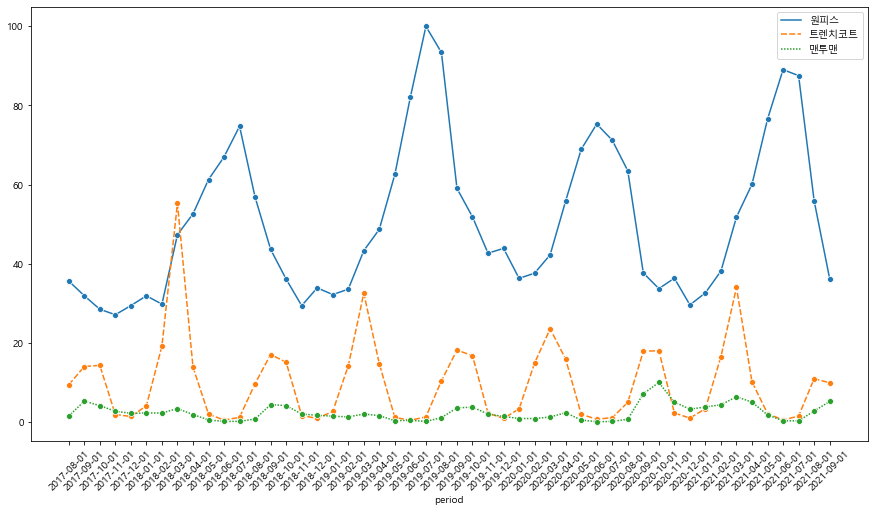

In [209]:
plt.figure(figsize=(15,8))
sns.lineplot(data = extracted_data_df, marker='o')
plt.xticks(rotation=45)
plt.show()

## 3. 데이터 분석

### 개별 키워드 정규화
* 키워드간 상대적인 트렌드 변화 정도를 비교하기 위해 정규화 후 데이터 활용

In [210]:
def apply_scale(col):
    scaled = (col - col.mean()) / col.std()
    return scaled

In [211]:
scaled_df = extracted_data_df.apply(apply_scale)
scaled_df.head()

,원피스,트렌치코트,맨투맨
period,,,
2017-08-01,-0.765653,-0.040478,-0.436182
2017-09-01,-0.956638,0.391559,1.358908
2017-10-01,-1.132615,0.419397,0.825052
2017-11-01,-1.203845,-0.741896,0.140042
2017-12-01,-1.084971,-0.787905,-0.099934


### 피크(계절성) 분석
* 1년 4계절 임으로 3개월 이상 차이나야 계절 차이로 인식 가능

In [212]:
# Peak 관련 데이터 추출 함수
def detect_seasonal(item_data):
    
    peaks, _ = find_peaks(item_data, distance = 3, height=-10) # 3개월 이상 간격을 두어야 계절성으로 판정
    peak_date = scaled_df.index[peaks].to_list()
    peak_heigh = _['peak_heights'].round(3).tolist()
    
    is_seasonal = False
    if len(peak_date) in [4,8,9]: # 4년동안 4번 또는 8번 peak 발생한 경우 피크로 판별(보완 필요)
        is_seasonal=True
        
    return is_seasonal

def extract_peak(item_data):
    peaks, _ = find_peaks(item_data, distance = 3, height=-10)
    peak_date = scaled_df.index[peaks].to_list()
    peak_heigh = _['peak_heights'].round(3).tolist()
    
    is_seasonal = False
    if len(peak_date) in [4,8,9]:
        is_seasonal=True
        
    return peak_date

def extract_height(item_data):
    peaks, _ = find_peaks(item_data, distance = 3, height=-10)
    peak_date = scaled_df.index[peaks].to_list()
    peak_heigh = _['peak_heights'].round(3).tolist()
    
    is_seasonal = False
    if len(peak_date) in [4,8,9]:
        is_seasonal=True
        
    return peak_heigh

def most_common(item_attr):
    # 가장 피크가 많은 month
    peak_month = pd.to_datetime(item_attr['peaks']).month_name()
    
    cnt = Counter(peak_month)
    
    cnt_list = []
    try:
        cnt_first = cnt.most_common()[0][0]
        cnt_second = cnt.most_common()[1][0]
        cnt_list = [cnt_first, cnt_second]
    except:
        cnt_first = cnt.most_common()[0][0]
        cnt_list = [cnt_first]
    
    return cnt_list

In [213]:
# 추출 시행
attr_df = pd.DataFrame(index = scaled_df.T.index)

scaled_df_T = scaled_df.T
attr_df['is_seasonal'] = pd.DataFrame(scaled_df_T.apply(detect_seasonal, axis=1))
attr_df['peaks'] = pd.DataFrame(scaled_df_T.apply(extract_peak, axis=1))
attr_df['heights'] = pd.DataFrame(scaled_df_T.apply(extract_height, axis=1))
attr_df['season'] = attr_df.apply(most_common, axis=1)

attr_df

,is_seasonal,peaks,heights,season
원피스,True,"[2018-01-01, 2018-07-01, 2018-12-01, 2019-07-0...","[-0.958, 1.244, -0.855, 2.542, -0.342, 1.273, ...","[July, December]"
트렌치코트,True,"[2017-10-01, 2018-03-01, 2018-09-01, 2019-03-0...","[0.419, 4.242, 0.675, 2.12, 0.78, 1.282, 0.765...","[March, October]"
맨투맨,True,"[2017-09-01, 2018-03-01, 2018-09-01, 2019-03-0...","[1.359, 0.466, 0.944, -0.188, -0.95, 0.639, -0...","[March, September]"


### 시각화
* 피크의 존재여부 및 그 시기를 도출 하였으나, 정확한 분석을 위해서는 실제 피크를 그려봐야 함

In [214]:
def plot_chart(items):
    peaks, _ = find_peaks(scaled_df[items], distance = 3, height=-10) # 1년 4계절 임으로 3개월 이상 차이나야 계절 차이로 인식 가능
    plt.figure(figsize=(16,6))
    plt.plot(scaled_df[items])
    plt.plot(peaks, scaled_df[items][peaks], "x")
    plt.plot(np.zeros_like(scaled_df[items]), "--", color="gray")
    plt.vlines(x=peaks, ymin=scaled_df[items].min(), ymax = scaled_df[items][peaks], color = "C1")
    plt.xticks(rotation=45)
    plt.show()

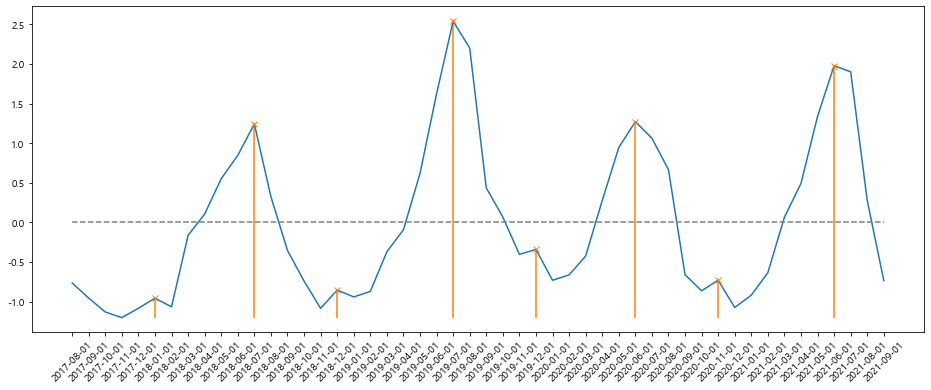

,is_seasonal,peaks,heights,season
원피스,True,"[2018-01-01, 2018-07-01, 2018-12-01, 2019-07-0...","[-0.958, 1.244, -0.855, 2.542, -0.342, 1.273, ...","[July, December]"


In [215]:
items = key_list[0]
plot_chart(items)
attr_df.loc[[items]]

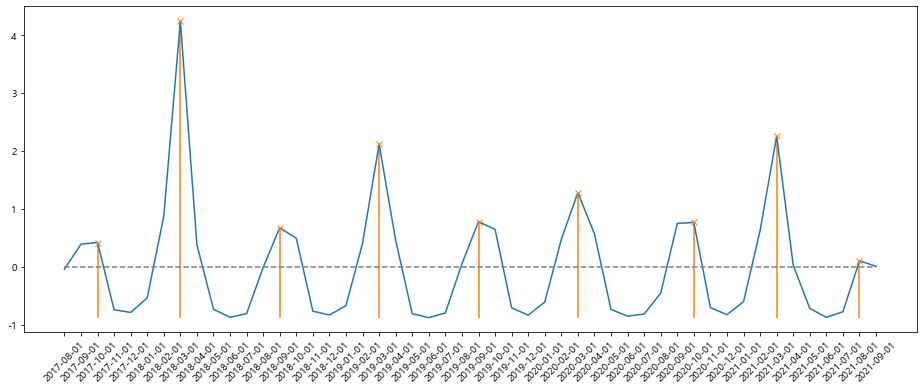

,is_seasonal,peaks,heights,season
트렌치코트,True,"[2017-10-01, 2018-03-01, 2018-09-01, 2019-03-0...","[0.419, 4.242, 0.675, 2.12, 0.78, 1.282, 0.765...","[March, October]"


In [216]:
items = key_list[1]
plot_chart(items)
attr_df.loc[[items]]

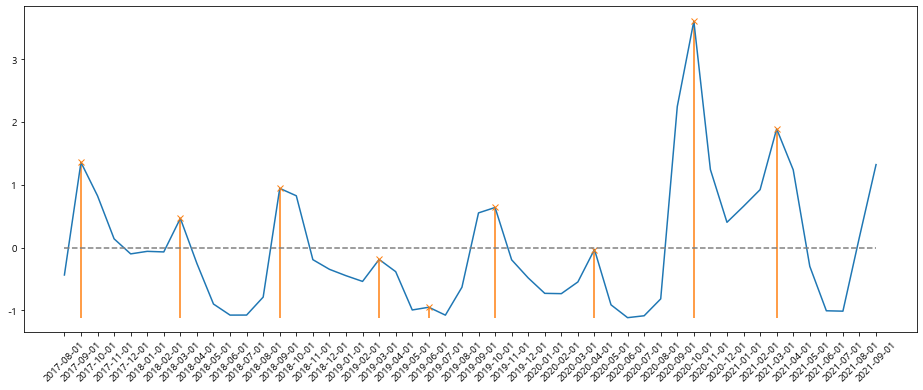

,is_seasonal,peaks,heights,season
맨투맨,True,"[2017-09-01, 2018-03-01, 2018-09-01, 2019-03-0...","[1.359, 0.466, 0.944, -0.188, -0.95, 0.639, -0...","[March, September]"


In [217]:
items = key_list[2]
plot_chart(items)
attr_df.loc[[items]]

### 트렌드 분석

In [218]:
def find_trend_const(item):
    X = list(range(len(item)))
    X = sm.add_constant(X)
    y = item.values.tolist()
    trend = sm.OLS(y, X).fit()
    return trend.params[0]

def find_trend_coef(item):
    X = list(range(len(item)))
    X = sm.add_constant(X)
    y = item.values.tolist()
    trend = sm.OLS(y, X).fit()
    return trend.params[1]

In [219]:
attr_df['trend_const'] = scaled_df_T.apply(find_trend_const, axis=1)
attr_df['trend_coef'] = scaled_df_T.apply(find_trend_coef, axis=1)
attr_df.sort_values(by=['trend_coef'], ascending=False)

,is_seasonal,peaks,heights,season,trend_const,trend_coef
원피스,True,"[2018-01-01, 2018-07-01, 2018-12-01, 2019-07-0...","[-0.958, 1.244, -0.855, 2.542, -0.342, 1.273, ...","[July, December]",-0.504053,0.020574
맨투맨,True,"[2017-09-01, 2018-03-01, 2018-09-01, 2019-03-0...","[1.359, 0.466, 0.944, -0.188, -0.95, 0.639, -0...","[March, September]",-0.320467,0.013080
트렌치코트,True,"[2017-10-01, 2018-03-01, 2018-09-01, 2019-03-0...","[0.419, 4.242, 0.675, 2.12, 0.78, 1.282, 0.765...","[March, October]",0.159451,-0.006508


In [220]:
def plot_trend_chart(items):
    peaks, _ = find_peaks(scaled_df[items], distance = 3, height=-10) # 14계절 인접계절 초과 판단으로 3개월 초과 피크 표현
    plt.figure(figsize=(16,6))
    plt.plot(scaled_df[items])
    plt.plot(peaks, scaled_df[items][peaks], "x")
    plt.plot(np.zeros_like(scaled_df[items]), "--", color="gray")
    plt.vlines(x=peaks, ymin=scaled_df[items].min(), ymax = scaled_df[items][peaks], color = "C1")

    plt.plot(scaled_df[items].index, attr_df.loc[items,'trend_const'] + np.arange(len(scaled_df[items].index)) * attr_df.loc[items,'trend_coef'])

    plt.xticks(rotation=45)
    plt.show()

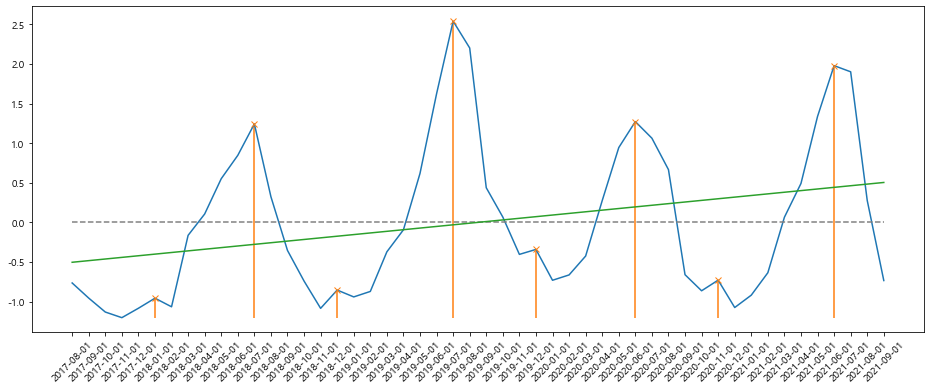

,is_seasonal,peaks,heights,season,trend_const,trend_coef
원피스,True,"[2018-01-01, 2018-07-01, 2018-12-01, 2019-07-0...","[-0.958, 1.244, -0.855, 2.542, -0.342, 1.273, ...","[July, December]",-0.504053,0.020574


In [221]:
item=key_list[0]
plot_trend_chart(item)
attr_df.loc[[item]]

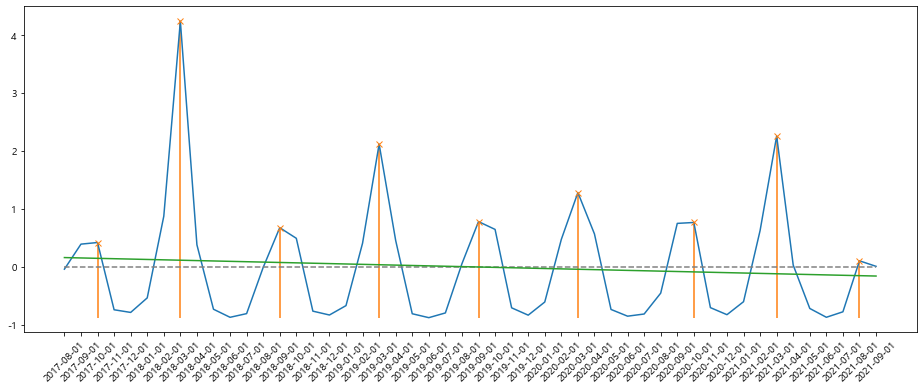

,is_seasonal,peaks,heights,season,trend_const,trend_coef
트렌치코트,True,"[2017-10-01, 2018-03-01, 2018-09-01, 2019-03-0...","[0.419, 4.242, 0.675, 2.12, 0.78, 1.282, 0.765...","[March, October]",0.159451,-0.006508


In [222]:
item=key_list[1]
plot_trend_chart(item)
attr_df.loc[[item]]

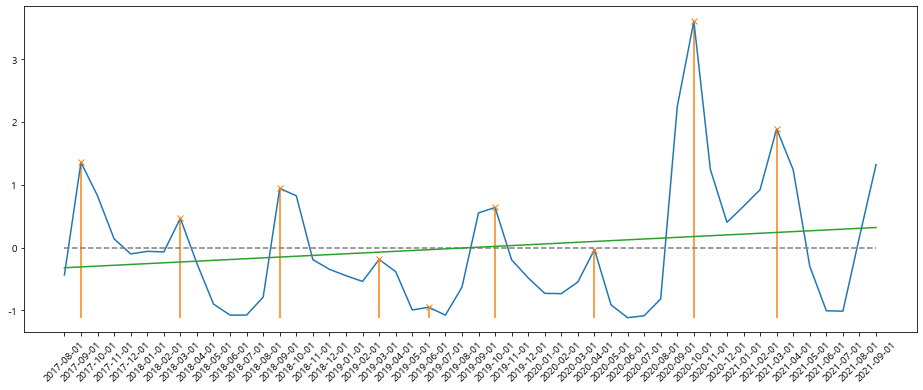

,is_seasonal,peaks,heights,season,trend_const,trend_coef
맨투맨,True,"[2017-09-01, 2018-03-01, 2018-09-01, 2019-03-0...","[1.359, 0.466, 0.944, -0.188, -0.95, 0.639, -0...","[March, September]",-0.320467,0.01308


In [223]:
item=key_list[2]
plot_trend_chart(item)
attr_df.loc[[item]]